In [2]:
import numpy as np
from sympy.physics.wigner import clebsch_gordan
import sympy as sp
from IPython.display import display, Math
import scipy.integrate as integ
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math



hbar = 1
me   = 1
mp = 1836.15
u = (me*mp)/(me+mp)
u=1
Z = 1
alfa = 1/137
c = 1/alfa

chi_alf = np.array([1,0])
chi_bet = np.array([0,1])

w,r, phi, theta , phi_p,theta_p = sp.symbols('w r phi theta phi_p theta_p', real=True)

dtheta = sp.lambdify(theta,sp.sin(theta),"numpy")


hart2cm = 455.633 # en angstroms
hart2ev = 27.2116 # en electronvoltios
hart2invcm = 219475
ua2Tesla = 2.35e5

thetvals,phivals = np.linspace(0.00001,np.pi-0.0001,700) , np.linspace(0.00001,2*np.pi-0.00001,700)
Tvals, Pvals = np.meshgrid(thetvals, phivals) # x, y


"""
Importamos las funciones definidas del anterior taller para asi usar los autoestados del atomo de hidrogeno
"""


def eferic_armonics_numeric(var1,var2,l,m):
    ef = (sp.sqrt((2*l+1)/(4*sp.pi) * sp.factorial(l-abs(m))/sp.factorial(l+abs(m)) )
          * sp.exp(sp.I * m * var2) * 1/(2**l * sp.factorial(l)) *
          (1-w**2)**(abs(m)/2)* sp.diff((w**2-1)**l,(w,l+abs(m))))
    ef = ef.subs(w,sp.cos(var1))
    return ef

def chi(s,ms):
    if ms == 1/2:
        return np.array([1,0])
    elif ms == -1/2:
        return np.array([0,1])

def chi_finder(f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi]
            return chi_bet
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0],
        return chi_alf


def Radial_part_numeric(var1,n,l):
    p = 2*Z*u/n  * var1
    radial = sp.S(0)
    for k in range(n-l):
        radial +=  (-1)**(k+1) * (sp.factorial(n+l))**2/ (sp.factorial(n-l-1-k)*sp.factorial(2*l+1+k)*sp.factorial(k)) * p**k

    radial *= - sp.sqrt(((2*Z*u/n)**3 * sp.factorial(n-l-1)/(2*n*(sp.factorial(n+l))**3  ))) * sp.exp(-p/2) * p**l

    return radial


def integrate_2d(Z, x, y, method):
    """
    Z: 2D array shaped (len(y), len(x))  -> f(y_i, x_j)
    x: 1D array (len Nx)
    y: 1D array (len Ny)
    method: 'rect', 'trapz', or 'simps'
    """
    if method == 'rect':
        dx = x[1]-x[0]
        dy = y[1]-y[0]
        return np.sum(Z) * dx * dy
    elif method == 'trapz':
        return np.trapezoid(np.trapezoid(Z, x=x, axis=1), x=y, axis=0)
    elif method == 'simps':
        return integ.simpson(integ.simpson(Z, x=x, axis=1), x=y, axis=0)
    else:
        raise ValueError("method must be 'rect','trapz' or 'simps'")


def safe_lambdify(vars, expr):
    f = sp.lambdify(vars, expr, "numpy")
    return lambda *args: np.broadcast_to(f(*args), np.broadcast(*args).shape)

def Psi(var1,var2,var3,n,l,ml,s,ms):
    psi = Radial_part_numeric(var1,n,l)*eferic_armonics_numeric(var2,var3,l,ml)*chi(s,ms)
    return psi


def L2_op (f):
    L2 = -hbar**2*(sp.diff(f,theta,2)   +  sp.cot(theta)*sp.diff(f,theta)+1/(sp.sin(theta))**2 *sp.diff(f,phi,2))
    return L2

def R_op(f):
    rop = -hbar**2/(2*u)* (sp.diff(f,r,2) + 2/r * sp.diff(f,r))
    return rop

def Hamiltonian(f):
    Ham = R_op(f) + 1/(2*u*r**2)*L2_op(f) -Z/r * f
    return Ham

def Matx_element_Op (f,op):
    # this finds the matrix element of an specific operator
    r_part = sp.integrate(np.dot(sp.conjugate(f),op)*r**2*sp.sin(theta),(r,0,sp.oo))
    r_part = safe_lambdify((theta,phi), r_part)

    sol = integrate_2d(r_part(Tvals,Pvals)*dtheta(Tvals),thetvals,phivals,'simps')

    return sol

def quantum_nums(f):

    ml = round(float(Matx_element_Op(f,Lz_op(theta,phi,np.dot(chi_alf+chi_bet,f))*chi_finder(f)  )))

    l_l_1 = float(Matx_element_Op(f,L2_op(np.dot(chi_alf+chi_bet,f))*chi_finder(f)    ))
    l_var = sp.symbols('l_var')
    y = l_var*(l_var+1) - l_l_1
    sol = sp.solve(y,l_var)
    l = round(max(sol))

    En = float(Matx_element_Op(f,Hamiltonian(np.dot(chi_alf+chi_bet,f))*chi_finder(f)   ))
    n = round(math.sqrt(-u*Z**2/(2*En)))

    s = 1/2

    chi = chi_finder(f)
    ms = 0
    if chi[0] == chi_alf[0]:
        ms = 1/2
    elif chi[1] == chi_bet[1]:
        ms = -1/2

    return [n,l,ml,s,ms]



def J2_op (f):
    j2 = L2_op(theta,phi,f) + L2_op(theta_p,phi_p,f) + 2*(Lx_op(theta,phi,f)+Ly_op(theta,phi,f)+Lz_op(theta,phi,f))* (Lx_op(theta_p,phi_p,f)+Ly_op(theta_p,phi_p,f)+Lz_op(theta_p,phi_p,f))
    return j2

def Jz_op (f):
    jz = Lz_op(theta,phi,f) + Lz_op(theta_p,phi_p,f)
    return jz


def clebseth_G(j1,j2,m1,m2,j,m,Sp_notSp_):
    if Sp_notSp_ == True:
        return sp.integrate(sp.integrate( np.dot(sp.conjugate(Y_S(j1,m1,j2,m2)) , eferic_armonics_numeric(theta,phi,j,m)* chi_finder(Y_S(j1,m1,j2,m2))  ) * sp.sin(theta),(theta,0,sp.pi)),(phi,0,2*sp.pi))
    else:
        return abs(sp.integrate(sp.integrate( sp.conjugate(Y1_Y2(j1,m1,j2,m2)) * eferic_armonics_numeric(theta,phi,j,m) *sp.sin(theta),(theta,0,sp.pi)),(phi,0,2*sp.pi)))

def Y1_Y2  (l,ml,lp,mp):
    mult_esferic = eferic_armonics_numeric(theta,phi,l,ml) * eferic_armonics_numeric(theta_p,phi_p,lp,mp)
    return mult_esferic

def Y_S (l,ml,s,ms):
    mult_esferic = eferic_armonics_numeric(theta,phi,l,ml) * chi(s,ms)
    return mult_esferic


def Lx_op (var1,var2,f):
    Lx = 1/2 * (Lplus_op(var1,var2,f)+Lminus_op(var1,var2,f))
    return Lx

def Ly_op (var1,var2,f):
    Ly= 1/(2*sp.I) * (Lplus_op(var1,var2,f)-Lminus_op(var1,var2,f))
    return Ly

def Lz_op (var1,var2,f):
    Lz = -sp.I*hbar*sp.diff(f,var2)
    return Lz

def Lplus_op(var1,var2,f):
    try :
        if float(np.sum(f)) == 0:
            return np.array([0,0])

    except TypeError:
        qnums = quantum_nums(f)
        l_l_1 = float(Matx_element_Op(f,L2_op(np.dot(chi_alf+chi_bet,f))*chi_finder(f)    ))

        if qnums[2] == qnums[1] :
            return np.array([0,0])
        else:
            return hbar* math.sqrt(l_l_1-qnums[2]*(qnums[2]+1)) *Psi(r,var1,var2,qnums[0],qnums[1],qnums[2]+1,qnums[3],qnums[4])

def Lminus_op(var1,var2,f):
    try :
        if float(np.sum(f)) == 0:
            return np.array([0,0])

    except TypeError:
        qnums = quantum_nums(f)
        l_l_1 = float(Matx_element_Op(f,L2_op(np.dot(chi_alf+chi_bet,f))*chi_finder(f)    ))

        if qnums[2] == -qnums[1] :
            return np.array([0,0])
        else:
            return hbar* math.sqrt(l_l_1-qnums[2]*(qnums[2]-1)) *Psi(r,var1,var2,qnums[0],qnums[1],qnums[2]-1,qnums[3],qnums[4])


def Splus_op(f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi]
            return hbar * np.array([f[1],0])
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0], S+ deberia de anular esto.
        return f[0] * np.array([0,0])

def Sminus_op(f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi] , el resultado seria anular
            return f[1] * np.array([0,0])
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0]
        return hbar * np.array([0,f[0]])

def S2_op (f):
    return  3/4 * hbar**2 * f

def Sx_op (f):
    sx = 1/2 * (Splus_op(f)+Sminus_op(f))
    return sx

def Sy_op (f):
    sy = 1/(sp.I*2) * (Splus_op(f)-Sminus_op(f))
    return sy


def Sz_op (f):
    try :
        if float(np.dot(chi_alf,f)) == 0: # significa que la función de onda tiene como ms = -1/2,  osea, f = [0,psi]
            return -1/2 * hbar * f
    except TypeError:
        # si llega hasta aca es porque capto que el producto punto es una función y no cero, lo que indica que la entrada es una función de onda con spin ms = +1/2
        # osea f = [psi,0],
        return 1/2 * hbar * f


# Definimos la matriz spin orbita como :

def SPO(f):

    spo = 1/2 * alfa**2 * Z/r**3 * (  Lz_op(theta,phi,np.dot(chi_alf+chi_bet,Sz_op(f)))*chi_finder(f)   + 1/2*(Lplus_op(theta,phi,Sminus_op(f)) + Lminus_op(theta,phi,Splus_op(f))    ))

    return spo

KeyboardInterrupt: 

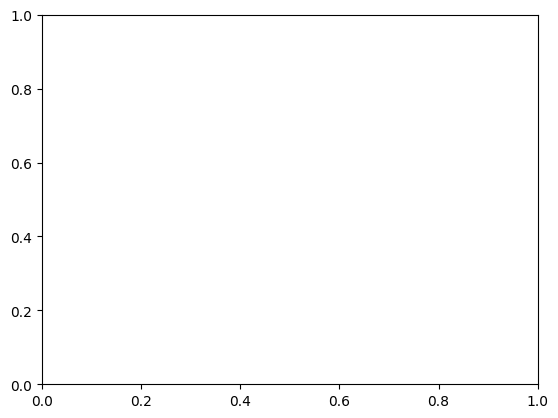

In [40]:
"""
Hallamos los elementos de matriz del hamiltoniano teniendo en cuenta los tres efectos
"""

# Vamos a definir entonces el operador.

def Haml_Zeeman (Bz,f):

    return  SPO(f)
             # 1/2* Bz * (Lz_op(theta,phi,np.dot(chi_alf+chi_bet,f))* chi_finder(f) +2*Sz_op(f)))


# Para el los estados:

n = 2
l = 1

# Recorreremos en ml y en ms para construir la matriz. y diagonalizar

Bz = np.linspace(0.001,2,1)
HZmatrix = np.zeros((6,6))
data =  np.zeros((6,len(Bz)))
MS = [-1/2,1/2]
i = 0
j = 0

fig1 ,ax = plt.subplots()

for k,bz in enumerate(Bz):
    for m1 in range(-l,l+1):
        for ms1 in range(2):
            for m2 in range(-l,l+1):
                for ms2 in range(2):
                    a = sp.integrate(np.dot(sp.conjugate(Psi(r,theta,phi,n,l,m1,1/2,MS[ms1])) , Haml_Zeeman(bz,Psi(r,theta,phi,n,l,m2,1/2,MS[ms2])))*r**2,(r,0,sp.oo))

                    b = sp.lambdify((theta,phi),a,'numpy')

                    HZmatrix[i,j] = integrate_2d(b(Tvals,Pvals)*dtheta(Tvals),thetvals,phivals,'simps')
                    HZmatrix[i,j] = np.round(HZmatrix[i,j],8)
                    j+=1
            j = 0
            i+= 1
    eig1, eig2 = np.linalg.eigh(HZmatrix)
    data[:,k] = np.round(eig1,5)
    i = 0
    j = 0



for k in range(6):
        ax.plot(Bz, data[k,:])

ax.grid()
ax.legend()





In [36]:
# print(data[:,:])
# fig2 ,ax1 = plt.subplots()
#
# for k in range(6):
#         ax1.plot(Bz, data[k,:])
#
# ax1.grid()
#
# ax1.set_xlim(-0.1,0.25)
# ax1.set_ylim(-0.13,-0.12)
print(HZmatrix)

[[ 5.5e-07  0.0e+00  0.0e+00 -0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00 -5.5e-07  3.1e-07  0.0e+00  0.0e+00 -0.0e+00]
 [ 0.0e+00  7.4e-07  0.0e+00  0.0e+00 -0.0e+00  0.0e+00]
 [ 0.0e+00 -0.0e+00  0.0e+00  0.0e+00  7.4e-07  0.0e+00]
 [-0.0e+00  0.0e+00  0.0e+00  3.1e-07 -5.5e-07  0.0e+00]
 [ 0.0e+00  0.0e+00 -0.0e+00  0.0e+00  0.0e+00  5.5e-07]]
